In [3]:
import pydicom as dicom
import matplotlib.pylab as plt
import numpy as np
import os
import skimage as ski
from skimage.transform import warp, AffineTransform, pyramid_expand, pyramid_reduce
import cv2
import scipy
from natsort import natsorted
from scipy.optimize import dual_annealing,basinhopping
# from sklearn.mixture import GaussianMixture
from skimage.registration import phase_cross_correlation
from scipy import ndimage as scp
from tqdm import tqdm
from skimage.metrics import normalized_root_mse as nrm
# from statsmodels.tsa.stattools import acf
import pickle
# from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA
from scipy.fftpack import fft2, fftshift, ifft2, fft, ifft
import time
import math
from skimage.exposure import equalize_hist
from skimage.exposure import equalize_adapthist
# from skimage.feature import SIFT, match_descriptors,plot_matches
# from skimage.feature import ORB
import ants.registration as ants_register
import ants
from scipy.optimize import minimize as minz
from scipy import optimize
import pickle
from skimage.filters import threshold_otsu
from skimage.metrics import normalized_mutual_information as nmi
from skimage.metrics import mean_squared_error as mse
from tifffile import imread as tiffread
import sys
from util_funcs import *

In [517]:

def ants_all_trans(data,UP,DOWN):
    transforms_all = np.tile(np.eye(3),(data.shape[0],1,1))
    for i in tqdm(range(data.shape[0]-1),desc='tr_all'):
        temp_img = data[i+1][UP:DOWN].copy()
        # PHASE
        coords = phase_cross_correlation(min_max(data[i][UP:DOWN][:,:])
                                        ,min_max(temp_img[:,:])
                                        ,normalization=None,upsample_factor=20)[0]
        if np.abs(coords[0])<=30:
            temp_img = warp(temp_img,AffineTransform(translation = (0,-coords[0])),order=3)
            tff = AffineTransform(translation = (0,-coords[0]))
            transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)

        # # ANTS
        # mat = scipy.io.loadmat(ants_reg_mapping(min_max(data[i][UP:DOWN][:,:]),min_max(temp_img[:,:]))[0])
        # mat = scipy.io.loadmat(ants_reg_mapping(min_max(data[i][UP:DOWN]),min_max(data[i+1][UP:DOWN]))[0])
        # if np.abs(mat['AffineTransform_float_2_2'][-2:][0][0])<=1000:
        #     tff = AffineTransform(translation = (0,mat['AffineTransform_float_2_2'][-2:][0][0]))
        #     transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)
    return transforms_all


# 5woWT

In [3]:
scan_num = '5woWT'
path = f'{scan_num}/'
pic_paths = []
for i in os.listdir(path):
    if i.endswith('.dcm') or  i.endswith('.DCM') or i.endswith('.PNG'):
        pic_paths.append(i)
pic_paths = np.array(natsorted(pic_paths))
fst = dicom.dcmread(path+pic_paths[0]).pixel_array

pics_without_line = np.empty((len(pic_paths),fst.shape[0],fst.shape[1]))
for i,j in tqdm(enumerate(pic_paths)):
    pics_without_line[i] = dicom.dcmread(path+j).pixel_array
pics_without_line = pics_without_line.astype(np.float32)

500it [00:06, 79.13it/s]


In [4]:
pics_without_line = pics_without_line[:,np.r_[1200:2200,6000:6900]]

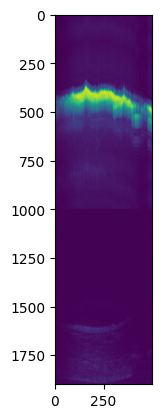

In [5]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [6]:
mid = 1000
UP,DOWN = 250,600
tr_all = ants_all_trans(pics_without_line,UP,DOWN)
for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
    pics_without_line[i][:mid]  = warp(pics_without_line[i][:mid],AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 500/500 [00:07<00:00, 66.41it/s]


In [7]:
# n = pics_without_line.shape[1]
# # nn = [np.argmax(np.sum(pics_without_line[i][:n//2],axis=1)) for i in range(pics_without_line.shape[0])]
# nn = [np.argmax(np.sum(pics_without_line[i][500:800],axis=1)) for i in range(pics_without_line.shape[0])]
# mid = 1000
# tf_all_nn = np.tile(np.eye(3),(pics_without_line.shape[0],1,1))
# for i in range(tf_all_nn.shape[0]):
#     tf_all_nn[i] = np.dot(tf_all_nn[i],AffineTransform(translation=(0,-(nn[0]-nn[i]))))
# for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
#     pics_without_line[i][:mid]  = warp(pics_without_line[i][:mid],AffineTransform(matrix=tf_all_nn[i]),order=3)

In [8]:
mid = 1000
UP,DOWN = 1500,1700
tr_all = ants_all_trans(pics_without_line,UP,DOWN)
for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
    pics_without_line[i][mid:]  = warp(pics_without_line[i][mid:],AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 500/500 [00:07<00:00, 71.43it/s]


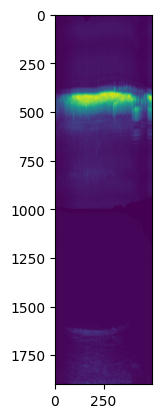

In [9]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [10]:
# nn = [np.argmax(np.sum(pics_without_line[i][1500:1700],axis=1)) for i in range(pics_without_line.shape[0])]
# mid = 1000
# tf_all_nn = np.tile(np.eye(3),(pics_without_line.shape[0],1,1))
# for i in range(tf_all_nn.shape[0]):
#     tf_all_nn[i] = np.dot(tf_all_nn[i],AffineTransform(translation=(0,-(nn[0]-nn[i]))))
# for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
#     pics_without_line[i][mid:]  = warp(pics_without_line[i][mid:],AffineTransform(matrix=tf_all_nn[i]),order=3)

In [11]:
# plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))
# nn = [np.argmax(np.sum(pics_without_line[i][:n//2],axis=1)) for i in range(pics_without_line.shape[0])]
# UP, DOWN = np.min(nn)-80,np.max(nn)+80

In [12]:
# tr_all = ants_all_trans(pics_without_line,UP,DOWN)
# for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
#     pics_without_line[i][:mid]  = warp(pics_without_line[i][:mid],AffineTransform(matrix=tr_all[i]),order=3)

In [13]:
# plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0)[1500:1700])

In [14]:
os.makedirs(f'registered/{scan_num}',exist_ok=True)
for i,j in tqdm(enumerate(pics_without_line)):
    cv2.imwrite(f'registered/{scan_num}/'+f'frame_test{i}.PNG',(min_max(j)*((2**16)-1)).astype(np.uint16))

500it [00:09, 50.16it/s]


# 5woFECD

In [15]:
scan_num = '5woFECD'
path = f'{scan_num}/'
pic_paths = []
for i in os.listdir(path):
    if i.endswith('.dcm') or  i.endswith('.DCM') or i.endswith('.PNG'):
        pic_paths.append(i)
pic_paths = np.array(natsorted(pic_paths))
fst = dicom.dcmread(path+pic_paths[0]).pixel_array

pics_without_line = np.empty((len(pic_paths),fst.shape[0],fst.shape[1]))
for i,j in tqdm(enumerate(pic_paths)):
    pics_without_line[i] = dicom.dcmread(path+j).pixel_array
pics_without_line = pics_without_line.astype(np.float32)

500it [00:02, 206.28it/s]


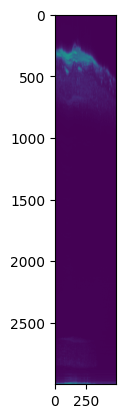

In [16]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [17]:
pics_without_line = pics_without_line[:,np.r_[:1000,2500:2900]]

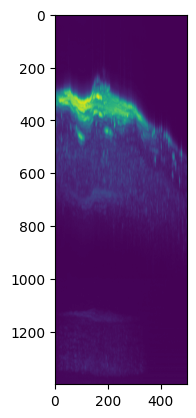

In [18]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [19]:
mid = 800
UP,DOWN = 200,600
tr_all = ants_all_trans(pics_without_line,UP,DOWN)
for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
    pics_without_line[i][:mid]  = warp(pics_without_line[i][:mid],AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 500/500 [00:05<00:00, 85.56it/s]


In [20]:
# n = pics_without_line.shape[1]
# # nn = [np.argmax(np.sum(pics_without_line[i][:n//2],axis=1)) for i in range(pics_without_line.shape[0])]
# nn = [np.argmax(np.sum(pics_without_line[i][200:600],axis=1)) for i in range(pics_without_line.shape[0])]
# mid = 800
# tf_all_nn = np.tile(np.eye(3),(pics_without_line.shape[0],1,1))
# for i in range(tf_all_nn.shape[0]):
#     tf_all_nn[i] = np.dot(tf_all_nn[i],AffineTransform(translation=(0,-(nn[0]-nn[i]))))
# for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
#     pics_without_line[i][:mid]  = warp(pics_without_line[i][:mid],AffineTransform(matrix=tf_all_nn[i]),order=3)

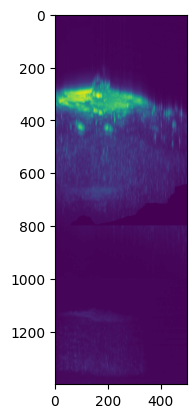

In [21]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [22]:
# nn = [np.argmax(np.sum(pics_without_line[i][1000:1250],axis=1)) for i in range(pics_without_line.shape[0])]
# mid = 800
# tf_all_nn = np.tile(np.eye(3),(pics_without_line.shape[0],1,1))
# for i in range(tf_all_nn.shape[0]):
#     tf_all_nn[i] = np.dot(tf_all_nn[i],AffineTransform(translation=(0,-(nn[0]-nn[i]))))
# for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
#     pics_without_line[i][mid:]  = warp(pics_without_line[i][mid:],AffineTransform(matrix=tf_all_nn[i]),order=3)

mid = 800
UP,DOWN = 1000,1250
tr_all = ants_all_trans(pics_without_line,UP,DOWN)
for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
    pics_without_line[i][mid:]  = warp(pics_without_line[i][mid:],AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 500/500 [00:04<00:00, 121.42it/s]


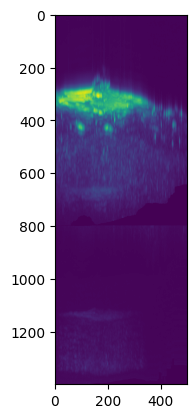

In [23]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [24]:
os.makedirs(f'registered/{scan_num}',exist_ok=True)
for i,j in tqdm(enumerate(pics_without_line)):
    cv2.imwrite(f'registered/{scan_num}/'+f'frame_test{i}.PNG',(min_max(j)*((2**16)-1)).astype(np.uint16))

500it [00:06, 71.96it/s]


# 16woWT

In [25]:
scan_num = '16woWT'
path = f'{scan_num}/'
pic_paths = []
for i in os.listdir(path):
    if i.endswith('.dcm') or  i.endswith('.DCM') or i.endswith('.PNG'):
        pic_paths.append(i)
pic_paths = np.array(natsorted(pic_paths))
fst = dicom.dcmread(path+pic_paths[0]).pixel_array

pics_without_line = np.empty((len(pic_paths),fst.shape[0],fst.shape[1]))
for i,j in tqdm(enumerate(pic_paths)):
    pics_without_line[i] = dicom.dcmread(path+j).pixel_array
pics_without_line = pics_without_line.astype(np.float32)

500it [00:01, 250.43it/s]


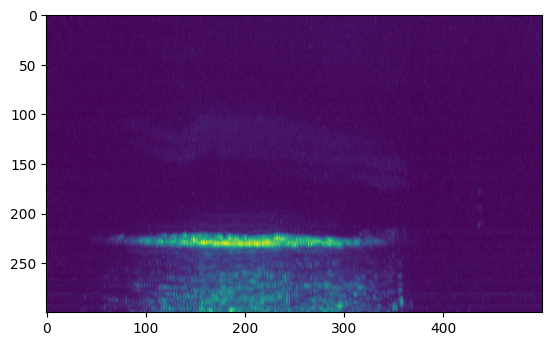

In [26]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0)[2100:2400])

In [27]:
pics_without_line = pics_without_line[:,np.r_[250:750,2100:2400]]

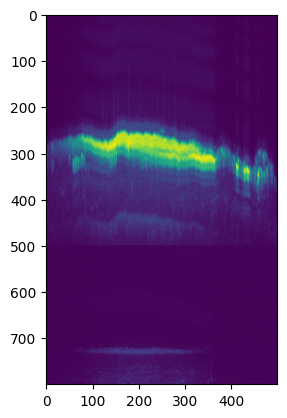

In [28]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [29]:
mid = 500
UP,DOWN = 200,420
tr_all = ants_all_trans(pics_without_line,UP,DOWN)
for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
    pics_without_line[i][:mid]  = warp(pics_without_line[i][:mid],AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 500/500 [00:03<00:00, 148.47it/s]


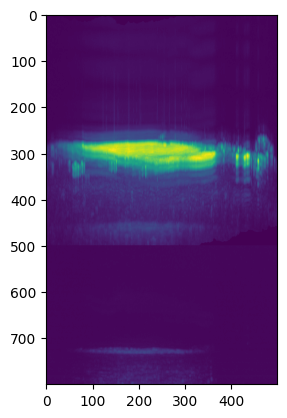

In [30]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [31]:
mid = 500
UP,DOWN = 650,800
tr_all = ants_all_trans(pics_without_line,UP,DOWN)
for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
    pics_without_line[i][mid:]  = warp(pics_without_line[i][mid:],AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 500/500 [00:02<00:00, 248.55it/s]


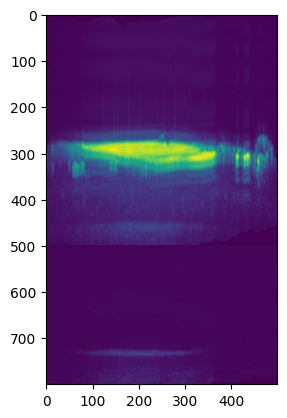

In [32]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [33]:
os.makedirs(f'registered/{scan_num}',exist_ok=True)
for i,j in tqdm(enumerate(pics_without_line)):
    cv2.imwrite(f'registered/{scan_num}/'+f'frame_test{i}.PNG',(min_max(j)*((2**16)-1)).astype(np.uint16))

500it [00:03, 129.40it/s]


# 16woFECD

In [34]:
scan_num = '16woFECD'
path = f'{scan_num}/'
pic_paths = []
for i in os.listdir(path):
    if i.endswith('.dcm') or  i.endswith('.DCM') or i.endswith('.PNG'):
        pic_paths.append(i)
pic_paths = np.array(natsorted(pic_paths))
fst = dicom.dcmread(path+pic_paths[0]).pixel_array

pics_without_line = np.empty((len(pic_paths),fst.shape[0],fst.shape[1]))
for i,j in tqdm(enumerate(pic_paths)):
    pics_without_line[i] = dicom.dcmread(path+j).pixel_array
pics_without_line = pics_without_line.astype(np.float32)

500it [00:01, 259.45it/s]


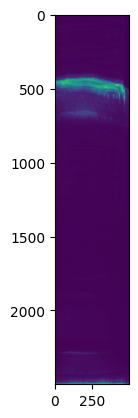

In [35]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [36]:
pics_without_line = pics_without_line[:,np.r_[200:900,2100:2400]]

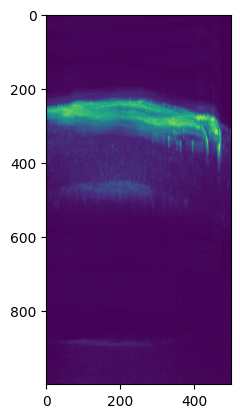

In [37]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [38]:
mid = 600
UP,DOWN = 190,420
tr_all = ants_all_trans(pics_without_line,UP,DOWN)
for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
    pics_without_line[i][:mid]  = warp(pics_without_line[i][:mid],AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 500/500 [00:04<00:00, 122.61it/s]


In [39]:
mid = 600
UP,DOWN = 800,1000
tr_all = ants_all_trans(pics_without_line,UP,DOWN)
for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
    pics_without_line[i][mid:]  = warp(pics_without_line[i][mid:],AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 500/500 [00:02<00:00, 183.63it/s]


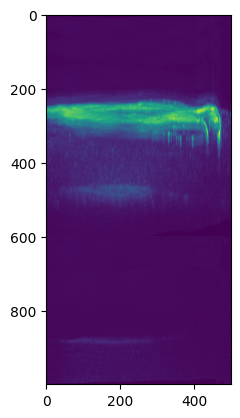

In [40]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [41]:
os.makedirs(f'registered/{scan_num}',exist_ok=True)
for i,j in tqdm(enumerate(pics_without_line)):
    cv2.imwrite(f'registered/{scan_num}/'+f'frame_test{i}.PNG',(min_max(j)*((2**16)-1)).astype(np.uint16))

500it [00:04, 106.43it/s]


# scan33

In [577]:
scan_num = 'scan33_ircard'
path = f'{scan_num}/'
pic_paths = []
for i in os.listdir(path):
    if i.endswith('.dcm') or  i.endswith('.DCM') or i.endswith('.PNG'):
        pic_paths.append(i)
pic_paths = np.array(natsorted(pic_paths))
fst = dicom.dcmread(path+pic_paths[0]).pixel_array

pics_without_line = np.empty((len(pic_paths),fst.shape[0],fst.shape[1]))
for i,j in tqdm(enumerate(pic_paths)):
    pics_without_line[i] = dicom.dcmread(path+j).pixel_array
pics_without_line = pics_without_line.astype(np.float32)

500it [00:01, 386.12it/s]


In [578]:
def ants_reg_mapping(stat,mov):
    ants1 = ants.from_numpy(stat.astype(np.float32))
    ants2 = ants.from_numpy(mov.astype(np.float32))
    reg = ants_register(ants1,ants2,type_of_transform = 'Translation',
                        aff_iterations=(1100, 1200, 500, 500))
    return reg['fwdtransforms']

def ants_all_trans(data,UP,DOWN):
    transforms_all = np.tile(np.eye(3),(data.shape[0],1,1))
    for i in tqdm(range(data.shape[0]-1),desc='tr_all'):
        temp_img = data[i+1].copy()
        # PHASE
        coords = phase_cross_correlation((data[i])
                                        ,(temp_img)
                                        ,normalization=None,upsample_factor=15)[0]
        if np.abs(coords[0])<=5:
            # temp_img = warp(temp_img,AffineTransform(translation = (0,-coords[0])),order=0)
            tff = AffineTransform(translation = (0,-coords[0]))
            transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)

        # ANTS
        # mat = scipy.io.loadmat(ants_reg_mapping(min_max(data[i][UP:DOWN][:,:50]),min_max(temp_img[:,:50]))[0])
        # # mat = scipy.io.loadmat(ants_reg_mapping(min_max(data[i][UP:DOWN]),min_max(data[i+1][UP:DOWN]))[0])
        # if np.abs(mat['AffineTransform_float_2_2'][-2:][0][0])<=5:
        #     tff = AffineTransform(translation = (0,mat['AffineTransform_float_2_2'][-2:][0][0]))
        #     transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)
    return transforms_all


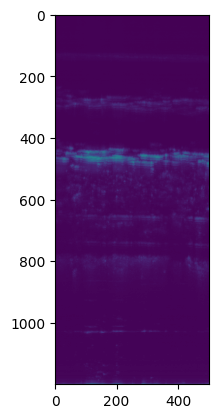

In [579]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [580]:
mid = 1000
UP,DOWN = 0,0
tr_all = ants_all_trans(pics_without_line,UP,DOWN)
for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
    pics_without_line[i][:mid]  = warp(pics_without_line[i][:mid],AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 500/500 [00:06<00:00, 73.12it/s]


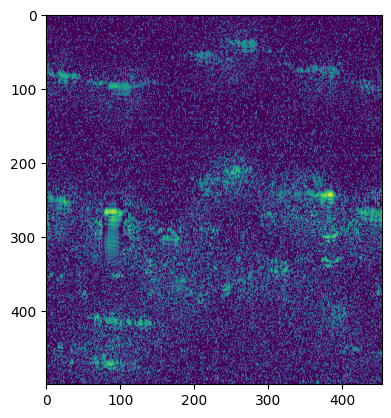

In [581]:
plt.imshow(thresh(denoise_fft(equalize_adapthist(min_max(pics_without_line[7][200:700]),clip_limit=0.04))))

In [582]:
arr_crop = ((equalize_adapthist(min_max(pics_without_line[7][200:700]),clip_limit=0.04)))
kk = top_5_masks(arr_crop)
window_view = 30
hole = kk[4]

rows, cols = arr_crop.shape  
row_start = max(0, hole[0] - window_view) # Ensure start is not less than 0
row_end = min(rows, hole[0] + window_view)  # Ensure end is not greater than rows
col_start = max(0, hole[1] - window_view) # Ensure start is not less than 0
col_end = min(cols, hole[1] + window_view) # Ensure end is not greater than cols


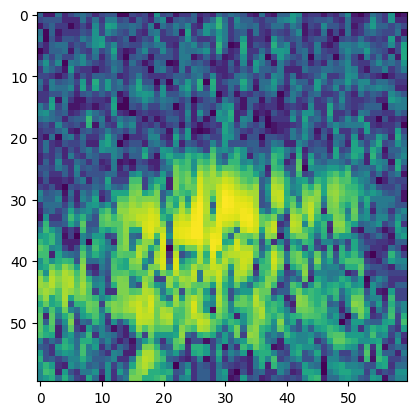

In [583]:
plt.imshow(arr_crop[row_start:row_end, col_start:col_end])

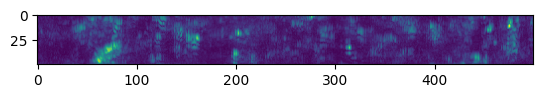

In [584]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0)[550:600])

In [615]:
def top_5_masks(data):
    arr = data.copy()
    top_5_centers = []
    window_remove = 50
    rows, cols = arr.shape  

    for _ in range(5):
        center_max = np.unravel_index(np.argmax(arr), arr.shape)
        top_5_centers.append(center_max)

        row_start = max(0, center_max[0] - window_remove) # Ensure start is not less than 0
        row_end = min(rows, center_max[0] + window_remove)  # Ensure end is not greater than rows
        col_start = max(0, center_max[1] - window_remove) # Ensure start is not less than 0
        col_end = min(cols, center_max[1] + window_remove) # Ensure end is not greater than cols

        arr[row_start:row_end, col_start:col_end] = 0

    return top_5_centers

# def mse_fun_tran(shif,x,y):
#     tform = AffineTransform(translation=(shif[0],0))
#     warped = warp(y, tform,order=3)
#     # warped = fourier_shift(y, (0,shif[0]))
#     return 1-ncc(x,warped)

def mse_fun_tran(shif,x,y):
    # tform = AffineTransform(translation=(shif[0],0))
    warped_y = warp(y, AffineTransform(translation=(shif[0],0)) ,order=3)
    warped_x = warp(y, AffineTransform(translation=(-shif[0],0)) ,order=3)
    # warped = fourier_shift(y, (0,shif[0]))
    return 2-nmi(warped_x,warped_y)

def ants_reg_mapping(stat,mov):
    ants1 = ants.from_numpy(stat.astype(np.float32))
    ants2 = ants.from_numpy(mov.astype(np.float32))
    reg = ants_register(ants1,ants2,type_of_transform = 'Affine')
    return reg['fwdtransforms']

def thresh(data):
    return data*(data>threshold_otsu(data))

def reg_loop(stat_img, mov_img, center_list):
    err_list = []
    transforms = []
    for i in range(len(center_list)):
        center = center_list[i]
        # Define the region of interest around the center
        window_view = 60
        row_start = max(0, center[0] - window_view) # Ensure start is not less than 0
        row_end = min(stat_img.shape[0], center[0] + window_view)  # Ensure end is not greater than rows
        col_start = max(0, center[1] - window_view) # Ensure start is not less than 0
        col_end = min(stat_img.shape[1], center[1] + window_view) # Ensure end is not greater than cols

        # Extract the region of interest
        stat_crop = stat_img[row_start:row_end, col_start:col_end].copy()
        mov_crop = mov_img[row_start:row_end, col_start:col_end].copy()

        temp_tform_manual = AffineTransform(translation=(0,0))
        # Perform registration on the cropped images
        for _ in range(20):
            move = minz(method='powell',fun = mse_fun_tran,x0 =(0),
                        args = (stat_crop
                                ,mov_crop))['x']
            temp_transform = AffineTransform(translation=(move[0]*2,0))
            mov_crop = warp(mov_crop, temp_transform,order=3)
            # mov_crop = fourier_shift(mov_crop, (0,move[0]))
            temp_tform_manual = np.dot(temp_tform_manual,temp_transform)
        
        warped_mov = warp(mov_img,temp_tform_manual,order=3)
        transforms.append(temp_tform_manual)
        err_list.append(1-ncc(stat_img,warped_mov))
    min_i = np.argmin(np.array(err_list))

    return center_list[min_i],transforms[min_i],err_list,transforms


transforms_all = np.tile(np.eye(3),(pics_without_line.shape[0],1,1))
UP,DOWN = 200,700
all_ncc = []
for i in tqdm(range(5,pics_without_line.shape[0]-1)):
    # temp_tform_manual = AffineTransform(translation=(0,0))
    static = (((min_max(pics_without_line[i][UP:DOWN])))).copy()
    temp_manual = (((min_max(pics_without_line[i+1][UP:DOWN])))).copy()
    _,tff,_,_ = reg_loop(static,temp_manual,top_5_masks(static))
    # for _ in range(20):
    #     move = minz(method='powell',fun = mse_fun_tran,x0 =(0),
    #                 args = (static
    #                         ,temp_manual))['x']
    #     temp_transform = AffineTransform(translation=(move[0],0))
    #     temp_manual = warp(temp_manual, temp_transform,order=4)
    #     temp_tform_manual = np.dot(temp_tform_manual,temp_transform)
    temp_tform_manual = AffineTransform(matrix = tff)
    # err = 1-ncc((pics_without_line[i][UP:DOWN])
    #             ,(pics_without_line[i+1][UP:DOWN]))
    # if np.abs(np.array(temp_tform_manual)[0,2])<=1.7:
    transforms_all[i+1:] = np.dot(transforms_all[i+1:],(temp_tform_manual))




100%|██████████| 494/494 [53:41<00:00,  6.52s/it]


In [455]:
static = (((min_max(pics_without_line[10][UP:DOWN])))).copy()
temp_manual = (((min_max(pics_without_line[10][UP:DOWN])))).copy()

In [469]:
import numpy as np

def fourier_shift(image, shift):
    """
    Shift an image by subpixel amounts using the Fourier shift theorem.

    Parameters:
      image : 2D numpy array (grayscale image)
      shift : tuple (dy, dx) with subpixel shifts (vertical, horizontal)

    Returns:
      shifted_image : 2D numpy array of the shifted image.
    """
    M, N = image.shape
    # Create frequency grids; np.fft.fftfreq returns frequencies in cycles per sample.
    u = np.fft.fftfreq(N)  # horizontal frequencies
    v = np.fft.fftfreq(M)  # vertical frequencies
    U, V = np.meshgrid(u, v)
    
    # Compute the phase shift multiplier for the desired shift
    # Note: shift is (dy, dx)
    phase_shift = np.exp(-2j * np.pi * (shift[1] * U + shift[0] * V))
    
    # Compute the FFT of the image
    F = np.fft.fft2(image)
    
    # Apply the phase shift in the frequency domain
    F_shifted = F * phase_shift
    
    # Compute the inverse FFT to obtain the shifted image
    shifted_image = np.fft.ifft2(F_shifted)
    
    # Return the real part (the imaginary part should be negligible)
    return np.real(shifted_image)




In [576]:
# # Suppose you want to shift your image by 0.6 pixels vertically and 0.4 pixels horizontally.
# a = np.zeros((10,10))
# b = np.zeros((10,10))
# a[3:5,4:6] = 1
# b[3:5,3:5] = 1
# temp = static[426-20:426+20, 240-20:240+20]

# plt.subplot(1,2,1)
# plt.imshow(temp)

# plt.subplot(1,2,2)
# # plt.imshow(warp(temp,AffineTransform(translation=(-0.5,0)),order=3))
# plt.imshow(fourier_shift(a,(0.4,0)))
# # plt.imshow(warp(a,AffineTransform(translation=(0.3,0)),order=4))

In [574]:
1-ncc(warp(a,AffineTransform(translation=(0.7,0)),order=3),warp(b,AffineTransform(translation=(-0.3,0)),order=3))

array([0.])

In [474]:
# %timeit (1 - ncc(static, warp(temp_manual,AffineTransform(translation=(0,0.4)),order=5)))
# %timeit (1 - ncc(static, warp(temp_manual,AffineTransform(translation=(0,0)),order=4)))
%timeit (1 - ncc(static, warp(temp_manual,AffineTransform(translation=(0,0)),order=3)))
%timeit (1 - ncc(static, fourier_shift(temp_manual, (0, 0))))

6.82 ms ± 371 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
22.6 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [553]:
print(top_5_masks(static))
reg_loop(static,temp_manual,top_5_masks(static))

[(281, 305), (257, 70), (252, 11), (276, 254), (426, 240)]


((426, 240),
 array([[1.        , 0.        , 0.37694496],
        [0.        , 1.        , 0.        ],
        [0.        , 0.        , 1.        ]]),
 [array([0.09664077], dtype=float32),
  array([0.09255862], dtype=float32),
  array([0.09432167], dtype=float32),
  array([0.09651786], dtype=float32),
  array([0.08469909], dtype=float32)],
 [array([[ 1.        ,  0.        , -0.06371994],
         [ 0.        ,  1.        ,  0.        ],
         [ 0.        ,  0.        ,  1.        ]]),
  array([[ 1.        ,  0.        , -0.18329508],
         [ 0.        ,  1.        ,  0.        ],
         [ 0.        ,  0.        ,  1.        ]]),
  array([[ 1.        ,  0.        , -0.14019588],
         [ 0.        ,  1.        ,  0.        ],
         [ 0.        ,  0.        ,  1.        ]]),
  array([[ 1.        ,  0.        , -0.06938884],
         [ 0.        ,  1.        ,  0.        ],
         [ 0.        ,  0.        ,  1.        ]]),
  array([[1.        , 0.        , 0.37694496],
 

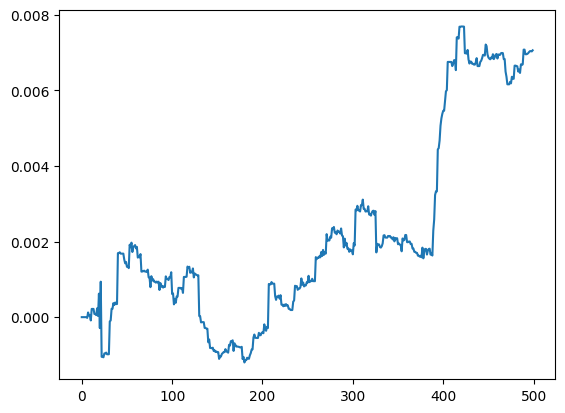

In [616]:
plt.plot(transforms_all[:,0,2])

In [592]:
gg = pics_without_line.copy()
# warp the images
for i in tqdm(range(gg.shape[0])):
    gg[i] = warp(gg[i],AffineTransform(matrix=transforms_all[i]),order=3)


100%|██████████| 500/500 [00:08<00:00, 58.34it/s]


In [593]:
os.makedirs(f'registered/{scan_num}',exist_ok=True)
gg = min_max(gg)
for i,j in tqdm(enumerate(gg)):
    cv2.imwrite(f'registered/{scan_num}/'+f'frame_test{i}.PNG',((j)*((2**8)-1)).astype(np.uint8))

500it [00:02, 204.73it/s]


In [603]:
scan_num = 'pic3'
path = f'{scan_num}/'
pic_paths = []
for i in os.listdir(path):
    if i.endswith('.dcm') or  i.endswith('.DCM') or i.endswith('.PNG'):
        pic_paths.append(i)
pic_paths = np.array(natsorted(pic_paths))
fst = dicom.dcmread(path+pic_paths[0]).pixel_array

pic3 = np.empty((len(pic_paths),fst.shape[0],fst.shape[1]))
for i,j in tqdm(enumerate(pic_paths)):
    pic3[i] = dicom.dcmread(path+j).pixel_array
# pics_without_line = pics_without_line.astype(np.float32)

500it [00:01, 447.48it/s]


In [604]:
pic3 = pic3[:,np.r_[350:800],:454]


In [605]:
def ants_reg_mapping(stat,mov):
    ants1 = ants.from_numpy(stat.astype(np.float32))
    ants2 = ants.from_numpy(mov.astype(np.float32))
    reg = ants_register(ants1,ants2,type_of_transform = 'Translation',
                        aff_iterations=(1100, 1200, 500, 500))
    return reg['fwdtransforms']

def ants_all_trans(data,UP,DOWN):
    transforms_all = np.tile(np.eye(3),(data.shape[0],1,1))
    for i in tqdm(range(data.shape[0]-1),desc='tr_all'):
        temp_img = data[i+1][UP:DOWN].copy()
        # PHASE
        coords = phase_cross_correlation((data[i][UP:DOWN][:,:50])
                                        ,(temp_img[:,:50])
                                        ,normalization=None,upsample_factor=15)[0]
        if np.abs(coords[0])<=30:
            # temp_img = warp(temp_img,AffineTransform(translation = (0,-coords[0])),order=0)
            tff = AffineTransform(translation = (0,-coords[0]))
            transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)

        # ANTS
        # mat = scipy.io.loadmat(ants_reg_mapping(min_max(data[i][UP:DOWN][:,:50]),min_max(temp_img[:,:50]))[0])
        # # mat = scipy.io.loadmat(ants_reg_mapping(min_max(data[i][UP:DOWN]),min_max(data[i+1][UP:DOWN]))[0])
        # if np.abs(mat['AffineTransform_float_2_2'][-2:][0][0])<=5:
        #     tff = AffineTransform(translation = (0,mat['AffineTransform_float_2_2'][-2:][0][0]))
        #     transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)
    return transforms_all


mid = 200
UP,DOWN = 20,120
tr_all = ants_all_trans(pic3,UP,DOWN)
for i in tqdm(range(pic3.shape[0]),desc='warping'):
    pic3[i][:mid]  = warp(pic3[i][:mid],AffineTransform(matrix=tr_all[i]),order=3)

mid = 200
UP,DOWN = 380,454
tr_all = ants_all_trans(pic3,UP,DOWN)
for i in tqdm(range(pic3.shape[0]),desc='warping'):
    pic3[i][mid:]  = warp(pic3[i][mid:],AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 500/500 [00:01<00:00, 266.15it/s]


In [617]:
gg2 = pic3.copy()
# warp the images
for i in tqdm(range(gg2.shape[0])):
    gg2[i] = warp(gg2[i],AffineTransform(matrix=transforms_all[i]).inverse,order=3)


100%|██████████| 500/500 [00:03<00:00, 148.17it/s]


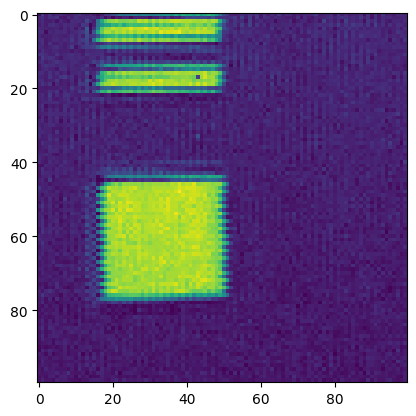

In [618]:
# plt.figure(figsize=(10,10))
plt.imshow((gg2.transpose(1,0,2)[100])[200:300,300:400])

In [40]:
os.makedirs(f'registered/{scan_num}',exist_ok=True)
gg2 = min_max(gg2)
for i,j in tqdm(enumerate(gg2)):
    cv2.imwrite(f'registered/{scan_num}/'+f'frame_test{i}.PNG',((j)*((2**8)-1)).astype(np.uint8))

500it [00:01, 489.00it/s]


# pic3

In [3]:
scan_num = 'pic3'
path = f'{scan_num}/'
pic_paths = []
for i in os.listdir(path):
    if i.endswith('.dcm') or  i.endswith('.DCM') or i.endswith('.PNG'):
        pic_paths.append(i)
pic_paths = np.array(natsorted(pic_paths))
fst = dicom.dcmread(path+pic_paths[0]).pixel_array

pics_without_line = np.empty((len(pic_paths),fst.shape[0],fst.shape[1]))
for i,j in tqdm(enumerate(pic_paths)):
    pics_without_line[i] = dicom.dcmread(path+j).pixel_array
# pics_without_line = pics_without_line.astype(np.float32)

500it [00:01, 456.79it/s]


In [4]:
def ants_reg_mapping(stat,mov):
    ants1 = ants.from_numpy(stat.astype(np.float32))
    ants2 = ants.from_numpy(mov.astype(np.float32))
    reg = ants_register(ants1,ants2,type_of_transform = 'Translation',
                        aff_iterations=(1100, 1200, 500, 500))
    return reg['fwdtransforms']

def ants_all_trans(data,UP,DOWN):
    transforms_all = np.tile(np.eye(3),(data.shape[0],1,1))
    for i in tqdm(range(data.shape[0]-1),desc='tr_all'):
        temp_img = data[i+1][UP:DOWN].copy()
        # PHASE
        coords = phase_cross_correlation((data[i][UP:DOWN][:,:50])
                                        ,(temp_img[:,:50])
                                        ,normalization=None,upsample_factor=15)[0]
        if np.abs(coords[0])<=30:
            # temp_img = warp(temp_img,AffineTransform(translation = (0,-coords[0])),order=0)
            tff = AffineTransform(translation = (0,-coords[0]))
            transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)

        # ANTS
        # mat = scipy.io.loadmat(ants_reg_mapping(min_max(data[i][UP:DOWN][:,:50]),min_max(temp_img[:,:50]))[0])
        # # mat = scipy.io.loadmat(ants_reg_mapping(min_max(data[i][UP:DOWN]),min_max(data[i+1][UP:DOWN]))[0])
        # if np.abs(mat['AffineTransform_float_2_2'][-2:][0][0])<=5:
        #     tff = AffineTransform(translation = (0,mat['AffineTransform_float_2_2'][-2:][0][0]))
        #     transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)
    return transforms_all


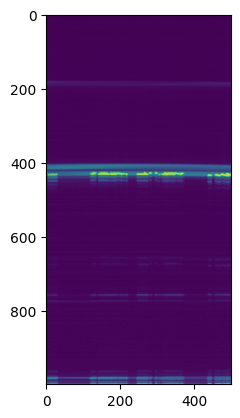

In [5]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [6]:
pics_without_line = pics_without_line[:,np.r_[350:800]]

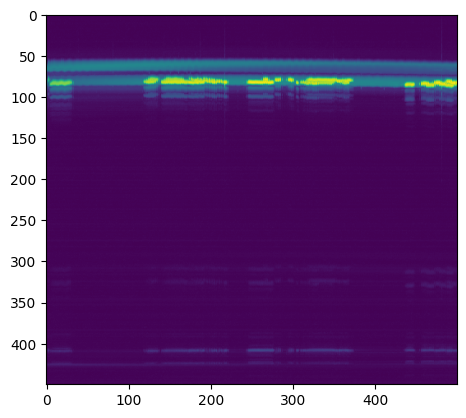

In [7]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [8]:
mid = 200
UP,DOWN = 20,120
tr_all = ants_all_trans(pics_without_line,UP,DOWN)
for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
    pics_without_line[i][:mid]  = warp(pics_without_line[i][:mid],AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 500/500 [00:01<00:00, 310.48it/s]


In [9]:
mid = 200
UP,DOWN = 380,454
tr_all = ants_all_trans(pics_without_line,UP,DOWN)
for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
    pics_without_line[i][mid:]  = warp(pics_without_line[i][mid:],AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 500/500 [00:02<00:00, 241.70it/s]


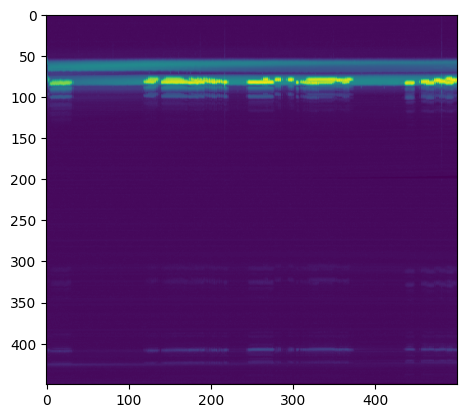

In [10]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [38]:
def mse_fun_tran(shif,x,y):
    tform = AffineTransform(translation=(shif[0],shif[1]))
    warped = warp(y, tform,order=3)
    return 1-ncc(x,warped)

def ants_reg_mapping(stat,mov):
    ants1 = ants.from_numpy(stat.astype(np.float32))
    ants2 = ants.from_numpy(mov.astype(np.float32))
    reg = ants_register(ants1,ants2,type_of_transform = 'Translation')
    return reg['fwdtransforms']

def thresh(data):
    return data*(data>threshold_otsu(data))

transforms_all = np.tile(np.eye(3),(pics_without_line.shape[0],1,1))
UP,DOWN = 50,100
all_ncc = []
for i in tqdm(range(5,pics_without_line.shape[0]-1)):
    # coords = phase_cross_correlation(thresh(pics_without_line[i][UP:DOWN])
    #                                 ,thresh(pics_without_line[i+1][UP:DOWN])
    #                                 ,normalization=None,upsample_factor=15)
    # tff = AffineTransform(translation = (-coords[0][1],0))
    # err = 1-ncc((pics_without_line[i][UP:DOWN])
    #             ,(pics_without_line[i+1][UP:DOWN]))
    # # err = coords[1]
    # if np.abs(coords[0][1])<2:
    #     transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)
    # all_ncc.append(err)

    temp_tform_manual = AffineTransform(translation=(0,0))
    temp_manual = pics_without_line[i+1][UP:DOWN].copy()
    for _ in range(50):
        move = minz(method='powell',fun = mse_fun_tran,x0 =(0,0),
                    args = ((pics_without_line[i][UP:DOWN])
                            ,(temp_manual)))['x']
        temp_transform = AffineTransform(translation=(move[0],move[1]))
        temp_manual = warp(temp_manual, temp_transform,order=3)
        temp_tform_manual = np.dot(temp_tform_manual,temp_transform)
    temp_tform_manual = AffineTransform(matrix = temp_tform_manual)
    # err = 1-ncc((pics_without_line[i][UP:DOWN])
    #             ,(pics_without_line[i+1][UP:DOWN]))
    if np.abs(np.array(temp_tform_manual)[0,2])<=2:
        # temp_img = warp(temp_img,temp_tform_manual,order=3)
        transforms_all[i+1:] = np.dot(transforms_all[i+1:],temp_tform_manual)
    # all_ncc.append(err)

    # mat = scipy.io.loadmat(ants_reg_mapping((pics_without_line[i][UP:DOWN])
    #                                         ,(pics_without_line[i+1][UP:DOWN]))[0])
    # tff = AffineTransform(translation = (mat['AffineTransform_float_2_2'][-2:][1,0],0))

    # err = 1-ncc((pics_without_line[i][np.r_[UP:DOWN]])
    #                     ,(warp(pics_without_line[i+1][np.r_[UP:DOWN]], tff,order=3)))
    # if err<0.006:
    #     transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)
    # all_ncc.append(err)

    # temp_tform_manual = AffineTransform(translation=(0,0)).params
    # temp_manual = pics_without_line[i+1][UP:DOWN].copy()
    # for _ in range(20):
    #     mat = scipy.io.loadmat(ants_reg_mapping((pics_without_line[i][UP:DOWN])
    #                                             ,(temp_manual))[0])
    #     # tff = AffineTransform(translation = (mat['AffineTransform_float_2_2'][-2:][1,0],0))
    #     temp_transform = AffineTransform(translation = (mat['AffineTransform_float_2_2'][-2:][1,0],0))
    #     temp_manual = warp(temp_manual, temp_transform,order=3)
    #     temp_tform_manual = np.dot(temp_tform_manual, temp_transform.params)
    # tff = AffineTransform(matrix = temp_tform_manual)

    # err = 1-ncc((pics_without_line[i][np.r_[UP:DOWN]])
    #             ,(warp(pics_without_line[i+1][np.r_[UP:DOWN]], tff,order=3)))
    # if np.abs(tff.params[0,2])<=2:
    #     transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)



100%|██████████| 494/494 [14:27<00:00,  1.76s/it]


In [39]:
gg = pics_without_line.copy()
# warp the images
for i in tqdm(range(gg.shape[0])):
    gg[i] = warp(gg[i],AffineTransform(matrix=transforms_all[i]),order=3)


100%|██████████| 500/500 [00:03<00:00, 153.68it/s]


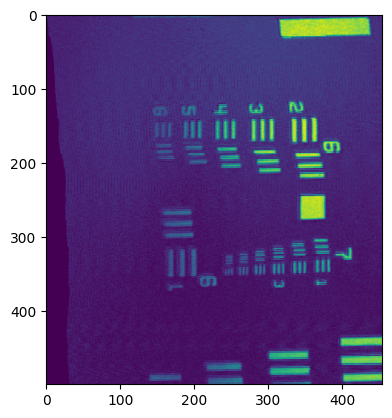

In [40]:
plt.imshow((gg.transpose(1,0,2)[100]))

In [24]:
os.makedirs(f'registered/{scan_num}',exist_ok=True)
gg = min_max(gg)
for i,j in tqdm(enumerate(gg)):
    cv2.imwrite(f'registered/{scan_num}/'+f'frame_test{i}.PNG',((j)*((2**16)-1)).astype(np.uint16))

500it [00:01, 251.00it/s]


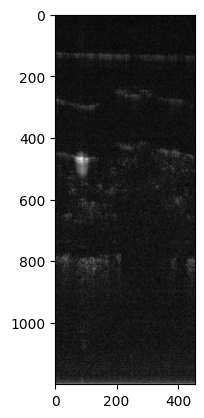

In [66]:
plt.imshow(equalize_adapthist(min_max(pics_without_line[20]),clip_limit=0.02),cmap='gray')

In [81]:
def mse_fun_tran(shif,x,y):
    tform = AffineTransform(translation=(shif[0],0))
    warped = warp(y, tform,order=3)
    return 1-ncc(x,warped)

In [ ]:
k = (min_max(pics_without_line[20][400:800]))
temp = warp(k,AffineTransform(translation=(1,0)),order=0)
temp_tff = AffineTransform(translation = (0,0))
init_move = 0
for _ in tqdm(range(2)):
        move = minz(method='powell',fun = mse_fun_tran,x0 =(0),
                        args = (k,
                                temp
                                ))['x']

        # move = dual_annealing(func = mse_fun_tran,
        #         bounds = [(-10,10)],
        #         args = (k,temp))['x']

        # mat = scipy.io.loadmat(ants_reg_mapping(k
        #                                 ,temp)[0])
        # move = [mat['AffineTransform_float_2_2'][-2:][1][0]]
        temp = warp(temp,AffineTransform(translation = (move[0],0)),order=3)
        init_move = move[0]
        temp_tff = np.dot(temp_tff,AffineTransform(translation = (move[0],0)))



100%|██████████| 2/2 [00:00<00:00,  2.83it/s]


In [151]:
mat = scipy.io.loadmat(ants_reg_mapping(k
                                ,temp)[0])
[mat['AffineTransform_float_2_2'][-2:][1][0]]

[0.003250122]

In [152]:
phase_cross_correlation(k,temp,normalization=None,upsample_factor=15)[0]

array([0., 0.], dtype=float32)

In [153]:
temp_tff

array([[ 1.        ,  0.        , -0.99335738],
       [ 0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])

In [60]:
def mse_fun_tran(shif,x,y):
    tform = AffineTransform(translation=(shif[0],0))
    warped = warp(y, tform,order=3)
    return 1-ncc(x,warped)

In [61]:
k = equalize_adapthist(min_max(pics_without_line[20][400:800]))

In [72]:
dual_annealing(func = mse_fun_tran,
                bounds = [(-30,30)],
                args = (k
                        ,warp(k,AffineTransform(translation=(0.4,0)))
                        ))['x']

array([-0.27999511])

In [71]:
minz(method='powell',fun = mse_fun_tran,x0 =(0),
                        args = (k,
                                warp(k,AffineTransform(translation=(0.4,0)))
                                ))['x']

array([-0.27996093])

In [37]:
dual_annealing(func = mse_fun_tran,
                bounds = [(-10,10)],
                args = (equalize_adapthist(min_max(pics_without_line[20]),clip_limit=0.02)[400:800]
                        ,equalize_adapthist(min_max(pics_without_line[21]),clip_limit=0.02)[400:800]))['x']

array([1.47603484])

In [244]:
mat = scipy.io.loadmat(ants_reg_mapping(equalize_adapthist(min_max(pics_without_line[20]),clip_limit=0.02)[400:800]
                                        ,equalize_adapthist(min_max(pics_without_line[21]),clip_limit=0.02)[400:800])[0])
(mat['AffineTransform_float_2_2'][-2:][1][0])

-0.6014557

-0.3553009